# Assignment 4 Exercises 9.1, 10.1, 11.1
Aaron Ou | 2018-04-23

In [1]:
rm(list = ls())
cat('\014') # clear console = Ctrl + L
library(ggplot2, verbose = FALSE, warn.conflicts = FALSE, quietly = TRUE)
library(dplyr, verbose = FALSE, warn.conflicts = FALSE, quietly = TRUE)
library(class) # knn()
library(repr)
library(grid)　# used to define multiplot()
library(glmnet) # for ridge and lasso regression
library(boot) # for bootstrap

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



### 9.1 KNN:

<!--Run KNN on the dataset using 3 different values for K. Compute the success rate and profits for each
approach. Discuss your results.
Margin per success = 1800; Sale cost per target = 180
-->

In [2]:
# Read the data. di refers to data of insurance
di <- read.csv("../Data/AutoInsurance.csv", header = TRUE)

# Basic summary
# names(di)
nrow(di)
summary(di$Purchase)

# % of Yes (basis of random guess)
348/(5474 + 348)

[1] 5822

No  Yes 
5474  348

[1] 0.05977327

In [3]:
# Scale the data
di_x <- di %>% select(-Purchase) %>% scale

# 20% as test dataset, roughly 1000 out of 5800
test_rows <- 1:1000
test_x <- di_x[test_rows, ]
test_y <- di[test_rows, "Purchase"]

# 80% as training data set
train_x <- di_x[-test_rows, ]
train_y <- di[-test_rows, "Purchase"]

In [4]:
# Fit the model on training dataset
set.seed(1)

ks <- c(1:15)
result <- list()
for (i in ks) {
  k <- ks[i]  
  test_pred <- knn(train = train_x, test = test_x, cl = train_y, k = k)
  # Test the model's fit on test dataset
  # Error rate, a.k.a Misclassification rate. e: error rate; s: success rate (Accuracy) = 1 - error rate
  e1 <- round(mean(test_y != test_pred), 3)
  accuracy <- 1 - e1

  # Confusion matrix to calculate True Positive Rates, defined as Sucess Rate in our case
  # The success rate of predicting Yes
  dt <- data.frame(test_pred, test_y)
  both_yes <- nrow(filter(dt, test_pred == "Yes", test_y == "Yes"))
  pred_yes <- nrow(filter(dt, test_pred == "Yes"))
  actual_yes <- nrow(filter(dt, test_y == "Yes"))
  success_rate <- ifelse(both_yes == 0 & pred_yes == 0, 0,
                    ifelse(both_yes == 0, 0,
                       round(both_yes / pred_yes, 3)))
  profit <- both_yes * 1800 - pred_yes * 180
  result0 <- data.frame(k = k, accuracy, success_rate, pred_yes, profit)  
  if(i == 1) result <- result0 else result <- rbind(result, result0)
}

result

k,accuracy,success_rate,pred_yes,profit
1,0.882,0.117,77,2340
2,0.891,0.097,62,-360
3,0.927,0.208,24,4680
4,0.930,0.238,21,5220
5,0.934,0.267,15,4500
6,0.938,0.364,11,5220
7,0.938,0.286,7,2340
8,0.939,0.333,6,2520
9,0.942,1.000,1,1620
10,0.941,0.000,0,0


In [5]:
# Scale profit to 0-1
result$profit2 <- round(result$profit/max(result$profit, na.rm = T), 3)
# Create max_profit data frame to plot vertical line later
max_profit <- result[result$profit2 == 1, ]

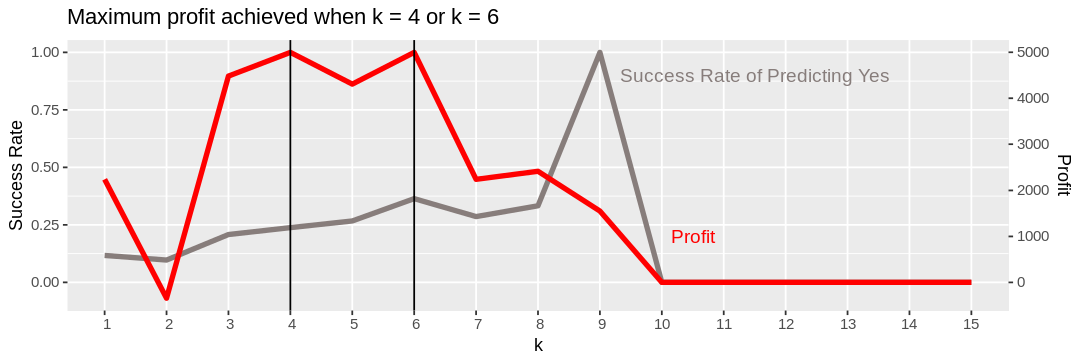

In [6]:
# Set plot size
options(repr.plot.width = 9, repr.plot.height = 3)

# Plot
ggplot(result, aes(x = k)) +
  geom_line(aes(y = success_rate), color = "#877d7b", size = 1.5) +
  geom_line(aes(y = profit2), color = "red", size = 1.5) +
  geom_vline(xintercept = max_profit$k, color = "black") +
  ylab("Success Rate") +
  scale_y_continuous(sec.axis = sec_axis(trans = ~.*5000, name = "Profit")) +
  scale_x_discrete(limits = ks) +
  annotate("text", label = "Success Rate of Predicting Yes", x = 11.5, y = 0.9, size = 4, colour = "#877d7b") +
  annotate("text", label = "Profit", x = 10.5, y = 0.2, size = 4, colour = "red") +
  ggtitle("Maximum profit achieved when k = 4 or k = 6")

In [7]:
max_profit

,k,accuracy,success_rate,pred_yes,profit,profit2
4,4,0.930,0.238,21,5220,1
6,6,0.938,0.364,11,5220,1


**Note**
- Those predicted Yes are sales target.　When sale target actually buys, it is Actual Yes, bringing a margin of 1800. Each sale effort costs 180.
- Profit = Margin × Actual Yes - Cost × Predict Yes

**Interpretation**
- As **k** increases from 1 to 9, the **Success Rate of Predicting Yes** increases accordingly till it reaches maximum when k = 9. Starting from k = 10 onwards, KNN model does not predict any Yes, basically discourage any sales efforts.
- As **k** increases, profit sees ups and downs. Profit reaches maximum when k = 4 or k = 6. Between the two, when k = 6, **pred_yes** is smaller, which suggests less sale efforts.

Therefore, **the optimal k value is 6**, where maximum profit is gained (5220) with least sales efforts (11).

### 10.1a Ridge:

<!--a) Fit a ridge regression model to the data from the Caravan auto insurance dataset using
outcome Purchase and all of the other variables in the dataset as predictors.
i. Load the data and necessary packages. Define the outcome using
y=as.factor(Insurance_Data'Purchase) and x matrix using the model.matrix()function. 
ii. Split the data into a test and training dataset.
iii. Fit a ridge regression to the test data over a grid of lambda values. You will need to
use the argument family=”binomial” in glmnet because the outcome is
binary. You must indicate this argument each time you use glmnet or cv.glmnet.
iv. Select the optimal lambda using cross-validation.
v. Fit a ridge regression using the optimal λ and report the test error rate. To calculate
the test error rate, you will need to re-format the test dataset outcome values
(y.test in code from lab above) to numeric values using as.numeric().
-->

In [8]:
# Load data
i0 <- read.csv("../Data/AutoInsurance.csv") %>% na.omit
x <- model.matrix(Purchase~., i0)[, -1]
dim(x)
y <- i0$Purchase
str(unique(y)) # Yes: 2, No: 1


# Split into test and training dataset
set.seed(1)
train <- sample(1:nrow(x), nrow(x)/2)
# train <- 1001:nrow(x) # training indices in KNN
test <- -train
y_test <- y[test]
# y_test <- as.numeric(y[test])

[1] 5822   85

 Factor w/ 2 levels "No","Yes": 1 2


In [9]:
# 1. Define function ===================================================
grid = 10^seq(10, -2, length = 100)
ReturnAlpha <- function(x) {ifelse(x == "ridge", 0, ifelse(x == "lasso", 1, NA))}

TestErrorRateAndCoef <- function(x, y, model_type) {   
  alpha_value <- ReturnAlpha(model_type)
  # Training dataset: fit model, choose tuning parameter lambda
  cv_out <- cv.glmnet(x[train, ], y[train], alpha = alpha_value, family = "binomial")
  # Find best lambda from cross validation
  bestlam <- cv_out$lambda.min # lambda.min is a variable name in the list `cv_out`
  
  cat(paste0("=== ", toupper(model_type), " REGRESSION ===\n"))  
  # Result 1: Predicted values ===========================================
  
  # Full dataset: fit model with a grid of lambda  
  mod <- glmnet(x, y, alpha = alpha_value, lambda = grid, family = "binomial")
  # Test dataset: predict y_test using model derived from full dataset and best lambda from Training
  y_pred <- predict(mod, s = bestlam, newx = x[test, ], type = "class")
  cat("--- Summary of predicted values on test data ---\n")
  cat(summary(y_pred)) 
  
  # Result 2: Test MSE ==================================================
  cat("\n\n--- Test MSE under best lambda (Outcome is binary) ---\n")
  # Since it is binary, unncessary to be transformed to numbers    
  # y_pred <- as.numeric(as.factor(y_pred))
  print(table(y_pred, y_test))
  mse <- round(mean(y_pred != y_test), 4)
  cat(paste0("\nTest MSE:  mean(y_pred != y_test) = ",  mse))
  
  # Result 3: Coefficients under best lambda ============================
  cat("\n\n--- Coefficients under best lambda ---\n")
  coeff <- predict(glmnet(x, y, alpha = alpha_value, family = "binomial"), type = "coefficients", s = bestlam)
  # coeff
  cat(paste0("Number of non-zero coefficients estimated: ", sum(as.numeric(coeff) != 0)))
}

In [10]:
# Ridge regression
set.seed(1)
TestErrorRateAndCoef(x, y, "ridge")

=== RIDGE REGRESSION ===
--- Summary of predicted values on test data ---
No :2908   Yes:   3  

--- Test MSE under best lambda (Outcome is binary) ---
      y_test
y_pred   No  Yes
   No  2731  177
   Yes    1    2

Test MSE:  mean(y_pred != y_test) = 0.0611

--- Coefficients under best lambda ---
Number of non-zero coefficients estimated: 86

### 10.1b Lasso:

<!--b) Repeat steps iii-v above using a lasso regression. Also report the number of non-zero
coefficients estimated. Compare the test error rates. Which is procedure do you think is
preferable?
-->

In [11]:
# Lasso regression
set.seed(1)
TestErrorRateAndCoef(x, y, "lasso")

=== LASSO REGRESSION ===
--- Summary of predicted values on test data ---
No :2910   Yes:   1  

--- Test MSE under best lambda (Outcome is binary) ---
      y_test
y_pred   No  Yes
   No  2732  178
   Yes    0    1

Test MSE:  mean(y_pred != y_test) = 0.0611

--- Coefficients under best lambda ---
Number of non-zero coefficients estimated: 32

**Interpretation**

As shown in the result above, the number of non-zero coefficients estimated is 32 out of 86 in Lasso as opposed to 86 in Ridge regression. Lasso is much better in "shrinking" some of the coefficients exactly to zero.

Comparing the test error rate (MSE), Lasso and Ridge are almost the same (0.0611).

In conclusion, Lasso is preferred.

### 10.1c:

<!--c) What do you notice about the predicted values for Purchase generated by Lasso and Ridge in
this case? How do they compare to those generated from KNN?
-->

In terms of predicted values for Purchase, the results between Lasso and Ridge are quite close to each other.

Note that neither Ridge or Lasso predicts much "Yes" in the outcome while KNN predicts more "Yes", which is more actionable and preferrable.

### 11.1a Bootstrap:

<!--a) Use the lm function to run an OLS regression of weight (explanatory variable) on acceleration (outcome) using the Auto dataset. Report and interpret the standard errors and coefficients.
-->

In [12]:
auto <- read.csv("../Data/Auto.csv")
summary(lm(acceleration ~ weight, data = auto))$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),19.572665810,0.4628600613,42.286357,9.544548e-148
weight,-0.001353896,0.0001494992,-9.056209,6.565616e-18


Coefficient: -0.0013539

Standard Error: 0.0001495

For every one addition unit of weight, the accelration will be -0.0013539 slower. Standard Error is small, p-value is small, statistically significant.


### 11.1b Bootstrap:

<!--b) Bootstrap the standard errors. How do your estimates compare to those generated by lm?
-->

In [13]:
# 1. Define function
BetaFn <- function(data, index){
  coef(lm(y ~ x, data, subset = index))
}

# 2. Repeat 1000 times in bootstrap
auto1 <- auto %>% select(acceleration, weight) %>%
  rename(x = weight, y = acceleration)

set.seed(1)
boot(auto1, statistic = BetaFn, R = 1000)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = auto1, statistic = BetaFn, R = 1000)


Bootstrap Statistics :
        original        bias     std. error
t1* 19.572665810  3.658635e-02 0.4226734830
t2* -0.001353896 -1.206432e-05 0.0001372339

**Interpretation**

The standard error from bootstrap is 0.0001372, somewhat different from 0.0001495 generated by lm.

Difference is also seen in a quadratic model as below.

In [14]:
# Quadratic model, bootstrap
BetaFn2 <- function(data, index) {
  coef(lm(y ~ x + I(x^2), data, subset = index)) 
}

set.seed(1)
boot(auto1, BetaFn2, 1000)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = auto1, statistic = BetaFn2, R = 1000)


Bootstrap Statistics :
         original        bias     std. error
t1*  1.566689e+01  8.155684e-02 1.756763e+00
t2*  1.287853e-03 -4.067256e-05 1.151767e-03
t3* -4.131442e-07  3.923306e-09 1.740913e-07

In [15]:
# Quadratic on full data set
summary(lm(y ~ x + I(x^2), data = auto1))$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),1.566689e+01,1.790161e+00,8.751665,6.476166e-17
x,1.287853e-03,1.179488e-03,1.091875,2.755640e-01
I(x^2),-4.131442e-07,1.829884e-07,-2.257761,2.451424e-02


### 11.1c Bootstrap:

<!--c) Do you think 11.1 a) Use the lm function to run an OLS regression of weight (explanatory variable) on acceleration (outcome) using the Auto dataset. Report and interpret the standard errors and coefficients.the assumptions required to use the traditional standard errors are fulfilled? Use the results of (a) and (b) as well as a scatterplot of weight and acceleration to support your answer.
-->

The assumptions required from simple linear regression are not fully met.

- The SE from bootstrap is somewhat different from that from lm.
- The scatter plot below also demonstrates that:
  - The relationship between dependent and independent variables is non-linear (red fit line)
  - Even fitted with linear (blue line), the error distribution is not normal

`geom_smooth()` using method = 'loess'


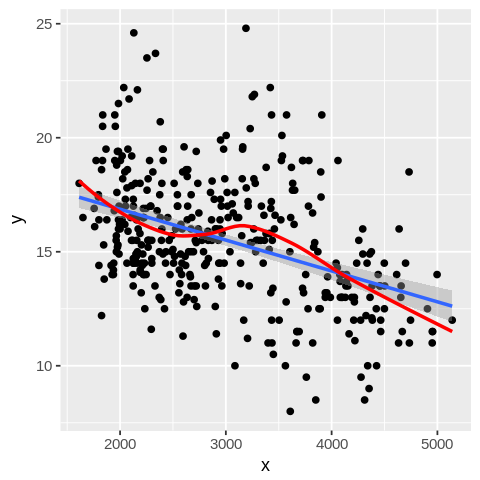

In [16]:
# Set plot size
options(repr.plot.width = 4, repr.plot.height = 4)

# Scatter plot
ggplot(auto1, aes(x, y)) +
  geom_point() +
  geom_smooth(method = "lm") +
  geom_smooth(color = "red", se = FALSE)